In [5]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle

def maximum_value_in_column(column):    
    highlight = 'font-weight: bold;'
    default = ''
    maximum_in_column = column.max()
    return [highlight if v == maximum_in_column else default for v in column]

def min_value_in_column(column):    
    highlight = 'font-weight: bold;'
    default = ''
    min_in_column = column.min()
    return [highlight if v == min_in_column else default for v in column]

def parse_synthetic_results(problem_map, save_dict=False):
    exp_dict = {'surrogate': [], 'acquisition': [], 'seed':[], 'problem_name':[], 'problem_idx':[], 'dim':[], 'data':[], 'dist_nearest_train':[], 'inst_regret_test':[], 'inst_regret_pool':[], 'tot_regret_test':[], 'tot_regret_pool':[], 'calibration_mse':[], 'sharpness':[], 'x_opt_dist_test':[], 'x_opt_dist_pool':[]}
    main_directory="./results_synth_data/"
    for foldername in os.listdir(main_directory):
        folder = os.path.join(main_directory, foldername)
        if os.path.isdir(folder):
            for filename in os.listdir(folder):
                if filename.find("parameters") != -1:
                    json_file = open(os.path.join(folder, filename))
                    params = json.load(json_file)
                elif filename.find("metrics") != -1:
                    json_file = open(os.path.join(folder, filename))
                    metrics = json.load(json_file)
            if params['bo'] == True:
                exp_dict['surrogate'].append(params['surrogate'])
                exp_dict['acquisition'].append(params['acquisition'])
                exp_dict['data'].append(params['data_name'])
                exp_dict['problem_idx'].append(params['problem_idx'])
                exp_dict['dim'].append(params['d'])
                exp_dict['problem_name'].append(problem_map[params[d]][params['problem_idx']])
                exp_dict['dist_nearest_train'].append(np.array(metrics['next_sample_train_distance']))
                exp_dict['inst_regret_test'].append(np.array(metrics['y_regret_test']))
                exp_dict['inst_regret_pool'].append(np.array(metrics['y_regret_pool']))
                exp_dict['tot_regret_test'].append(np.cumsum(metrics['y_regret_test']))
                exp_dict['tot_regret_pool'].append(np.cumsum(metrics['y_regret_pool']))
                exp_dict['x_opt_dist_pool'].append(np.array(metrics['x_y_opt_dist_pool']))
                exp_dict['x_opt_dist_test'].append(np.array(metrics['x_y_opt_dist_test']))
                exp_dict['sharpness'].append(np.array(metrics['mean_sharpness']))
                exp_dict['calibration_mse'].append(np.array(metrics['y_calibration_mse']))
                exp_dict['seed'].append(params['seed'])
    if save_dict:
        with open('parsed_results/synth_results.obj', 'wb') as save_file:
            pickle.dump(exp_dict, save_file)
    df = pd.DataFrame.from_dict(exp_dict)
    return df

def aggregate_synthetic_results(df):
    processed_results = {'surrogate': [], 'acquisition': [], 'seed':[], 'problem_idx':[], 'dim':[], 'data':[], 'dist_nearest_train':[], 'inst_regret_test':[], 'inst_regret_pool':[], 'tot_regret_test':[], 'tot_regret_pool':[], 'calibration_mse':[], 'sharpness':[], 'x_opt_dist_test':[], 'x_opt_dist_pool':[]}
    for index, row in df.iterrows():
        processed_results['surrogate'].append(row['surrogate'])
        processed_results['acquisition'].append(row['acquisition'])
        processed_results['data'].append(row['data'])
        processed_results['seed'].append(row['seed'])
        processed_results['problem_idx'].append(row['problem_idx'])
        processed_results['dim'].append(row['dim'])
        processed_results['dist_nearest_train'].append(np.array(row['dist_nearest_train']).astype(float).mean()) #Mean across one BO run.
        processed_results['inst_regret_pool'].append(np.array(row['inst_regret_pool'])[-1]) #Last iter.
        processed_results['inst_regret_test'].append(np.array(row['inst_regret_test'])[-1]) #Last iter.
        processed_results['tot_regret_test'].append(np.array(row['tot_regret_test'])[-1]) #Last iter.
        processed_results['tot_regret_pool'].append(np.array(row['tot_regret_pool'])[-1]) #Last iter.
        processed_results['calibration_mse'].append(np.array(row['calibration_mse']).mean(axis=0)) #Mean Calibration MSE over run.
        processed_results['sharpness'].append(np.array(row['sharpness']).mean()) #Mean sharpness over run.
        processed_results['x_opt_dist_test'].append(np.array(row['x_opt_dist_test'])[-1])
        processed_results['x_opt_dist_pool'].append(np.array(row['x_opt_dist_pool'])[-1])
    df = pd.DataFrame.from_dict(processed_results)
    return df

def BO_performance_table1_synth_results(df):
    acqs = list(set(df['acquisition']))
    surrogates = list(set(df['surrogate']))
    seeds = len(list(set(df['seed'])))
    aggregated_processed_results = {'surrogate': [], 'acquisition': [], 'inst_regret_pool':[], 'inst_regret_pool_ste':[], 'tot_regret_pool':[], 'tot_regret_pool_ste':[], 'calibration_mse':[], 'calibration_mse_ste':[], 'sharpness':[], 'sharpness_ste':[]}
    #Aggregate results for pairs of surrogates and acquisitions.
    for acq in acqs:
        for surrogate in surrogates:
            selection = df.loc[((df['acquisition']==acq) & (df['surrogate']==surrogate))]
            aggregated_processed_results['surrogate'].append(surrogate)
            aggregated_processed_results['acquisition'].append(acq)
            aggregated_processed_results['inst_regret_pool'].append(np.mean(selection['inst_regret_pool']))
            aggregated_processed_results['inst_regret_pool_ste'].append(np.std(selection['inst_regret_pool'])/np.sqrt(len(selection['surrogate'])))
            aggregated_processed_results['tot_regret_pool'].append(np.mean(selection['tot_regret_pool']))
            aggregated_processed_results['tot_regret_pool_ste'].append(np.std(selection['tot_regret_pool'])/np.sqrt(len(selection['surrogate'])))
            aggregated_processed_results['calibration_mse'].append(np.mean(selection['calibration_mse']))
            aggregated_processed_results['calibration_mse_ste'].append(np.std(selection['calibration_mse'])/np.sqrt(len(selection['surrogate'])))
            aggregated_processed_results['sharpness'].append(np.mean(selection['sharpness']))
            aggregated_processed_results['sharpness_ste'].append(np.std(selection['sharpness'])/np.sqrt(len(selection['surrogate'])))
    #Aggregate results of surrogates without including random sampling acquisition.
    for surrogate in surrogates:
        selection = df.loc[(df['surrogate']==surrogate) & (df['acquisition'] != "RS")]
        aggregated_processed_results['surrogate'].append(surrogate)
        aggregated_processed_results['acquisition'].append("avg")
        aggregated_processed_results['inst_regret_pool'].append(np.mean(selection['inst_regret_pool']))
        aggregated_processed_results['inst_regret_pool_ste'].append(np.std(selection['inst_regret_pool'])/np.sqrt(len(selection['surrogate'])))
        aggregated_processed_results['tot_regret_pool'].append(np.mean(selection['tot_regret_pool']))
        aggregated_processed_results['tot_regret_pool_ste'].append(np.std(selection['tot_regret_pool'])/np.sqrt(len(selection['surrogate'])))
        aggregated_processed_results['calibration_mse'].append(np.mean(selection['calibration_mse']))
        aggregated_processed_results['calibration_mse_ste'].append(np.std(selection['calibration_mse'])/np.sqrt(len(selection['surrogate'])))
        aggregated_processed_results['sharpness'].append(np.mean(selection['sharpness']))
        aggregated_processed_results['sharpness_ste'].append(np.std(selection['sharpness'])/np.sqrt(len(selection['surrogate'])))
    df = pd.DataFrame.from_dict(aggregated_processed_results)
    df = df.round(4)
    latex_df = pd.DataFrame(columns=['Surrogate', 'Acquisition', 'Inst. Regret', 'Total Regret', 'Calibration Error', 'Sharpness'])
    latex_df['Surrogate'] = df['surrogate']
    latex_df['Acquisition'] = df['acquisition']
    latex_df['Inst. Regret'] = df['inst_regret_pool'].astype(str) + " \pm " + df['inst_regret_pool_ste'].astype(str)
    latex_df['Total Regret'] = df['tot_regret_pool'].astype(str) + " \pm " + df['tot_regret_pool_ste'].astype(str)
    latex_df['Calibration Error'] = df['calibration_mse'].astype(str) + " \pm " + df['calibration_mse_ste'].astype(str)
    latex_df['Sharpness'] = df['sharpness'].astype(str) + " \pm " + df['sharpness_ste'].astype(str)
    table_with_highlight = df.style.apply(min_value_in_column, subset=['inst_regret_pool', "tot_regret_pool", 'calibration_mse'], axis=0)
    return table_with_highlight, latex_df

def parse_real_results(save_dict=False):
    exp_dict = {'surrogate': [], 'acquisition': [], 'seed':[], 'data':[], 'dist_nearest_train':[], 'inst_regret_test':[], 'inst_regret_pool':[], 'tot_regret_test':[], 'tot_regret_pool':[], 'calibration_mse':[], 'sharpness':[], 'x_opt_dist_test':[], 'x_opt_dist_pool':[]}
    main_directory="./results_real_data/"
    subdirectories = ['results_FashionMNIST/', "results_FashionMNIST_CNN/", 'results_mnist/', 'results_MNIST_CNN/', 'results_News/', 'results_SVM/']
    for subdirectory in subdirectories:
        full_path = os.path.join(main_directory, subdirectory)
        for foldername in os.listdir(full_path):
            folder = os.path.join(full_path, foldername)
            if os.path.isdir(folder):
                for filename in os.listdir(folder):
                    if filename.find("parameters") != -1:
                        json_file = open(os.path.join(folder, filename))
                        params = json.load(json_file)
                    elif filename.find("metrics") != -1:
                        json_file = open(os.path.join(folder, filename))
                        metrics = json.load(json_file)
                if params['bo'] == True:
                    exp_dict['surrogate'].append(params['surrogate'])
                    exp_dict['acquisition'].append(params['acquisition'])
                    exp_dict['data'].append(params['data_name'])
                    exp_dict['dist_nearest_train'].append(metrics['next_sample_train_distance'])
                    exp_dict['inst_regret_test'].append(metrics['y_regret_test'])
                    exp_dict['inst_regret_pool'].append(metrics['y_regret_pool'])
                    exp_dict['tot_regret_test'].append(np.cumsum(metrics['y_regret_test']))
                    exp_dict['tot_regret_pool'].append(np.cumsum(metrics['y_regret_pool']))
                    exp_dict['x_opt_dist_pool'].append(metrics['x_y_opt_dist_pool'])
                    exp_dict['x_opt_dist_test'].append(metrics['x_y_opt_dist_test'])
                    exp_dict['sharpness'].append(metrics['mean_sharpness'])
                    exp_dict['calibration_mse'].append(metrics['y_calibration_mse'])
                    exp_dict['seed'].append(params['seed'])
    df = pd.DataFrame.from_dict(exp_dict)
    if save_dict:
        with open('parsed_results/real_results.obj', 'wb') as save_file:
            pickle.dump(exp_dict, save_file)
    return df

def aggregate_real_results(df):
    processed_results = {'surrogate': [], 'acquisition': [], 'seed':[], 'data':[], 'dist_nearest_train':[], 'inst_regret_test':[], 'inst_regret_pool':[], 'tot_regret_test':[], 'tot_regret_pool':[], 'calibration_mse':[], 'sharpness':[], 'x_opt_dist_test':[], 'x_opt_dist_pool':[]}
    for index, row in df.iterrows():
        processed_results['surrogate'].append(row['surrogate'])
        processed_results['acquisition'].append(row['acquisition'])
        processed_results['data'].append(row['data'])
        processed_results['seed'].append(row['seed'])
        processed_results['dist_nearest_train'].append(np.array(row['dist_nearest_train']).astype(float).mean()) #Mean across one BO run.
        processed_results['inst_regret_pool'].append(np.array(row['inst_regret_pool'])[-1]) #Last iter.
        processed_results['inst_regret_test'].append(np.array(row['inst_regret_test'])[-1]) #Last iter.
        processed_results['tot_regret_test'].append(np.array(row['tot_regret_test'])[-1]) #Last iter.
        processed_results['tot_regret_pool'].append(np.array(row['tot_regret_pool'])[-1]) #Last iter.
        processed_results['calibration_mse'].append(np.array(row['calibration_mse']).mean(axis=0)) #Mean Calibration MSE over run.
        processed_results['sharpness'].append(np.array(row['sharpness']).mean()) #Mean sharpness over run.
        processed_results['x_opt_dist_test'].append(np.array(row['x_opt_dist_test'])[-1])
        processed_results['x_opt_dist_pool'].append(np.array(row['x_opt_dist_pool'])[-1])
    df = pd.DataFrame.from_dict(processed_results)
    return df

def BO_performance_table1_real_results(df):
    acqs = list(set(df['acquisition']))
    surrogates = list(set(df['surrogate']))
    aggregated_processed_results = {'surrogate': [], 'acquisition': [], 'inst_regret_pool':[], 'inst_regret_pool_ste':[], 'tot_regret_pool':[], 'tot_regret_pool_ste':[], 'calibration_mse':[], 'calibration_mse_ste':[], 'sharpness':[], 'sharpness_ste':[]}
    #Aggregate results for pairs of surrogates and acquisitions.
    for acq in acqs:
        for surrogate in surrogates:
            selection = df.loc[((df['acquisition']==acq) & (df['surrogate']==surrogate))]
            aggregated_processed_results['surrogate'].append(surrogate)
            aggregated_processed_results['acquisition'].append(acq)
            aggregated_processed_results['inst_regret_pool'].append(np.mean(selection['inst_regret_pool']))
            aggregated_processed_results['inst_regret_pool_ste'].append(np.std(selection['inst_regret_pool'])/np.sqrt(len(selection['surrogate'])))
            aggregated_processed_results['tot_regret_pool'].append(np.mean(selection['tot_regret_pool']))
            aggregated_processed_results['tot_regret_pool_ste'].append(np.std(selection['tot_regret_pool'])/np.sqrt(len(selection['surrogate'])))
            aggregated_processed_results['calibration_mse'].append(np.mean(selection['calibration_mse']))
            aggregated_processed_results['calibration_mse_ste'].append(np.std(selection['calibration_mse'])/np.sqrt(len(selection['surrogate'])))
            aggregated_processed_results['sharpness'].append(np.mean(selection['sharpness']))
            aggregated_processed_results['sharpness_ste'].append(np.std(selection['sharpness'])/np.sqrt(len(selection['surrogate'])))
    #Aggregate results of surrogates without including random sampling acquisition.
    for surrogate in surrogates:
        selection = df.loc[(df['surrogate']==surrogate) & (df['acquisition'] != "RS")]
        aggregated_processed_results['surrogate'].append(surrogate)
        aggregated_processed_results['acquisition'].append("avg")
        aggregated_processed_results['inst_regret_pool'].append(np.mean(selection['inst_regret_pool']))
        aggregated_processed_results['inst_regret_pool_ste'].append(np.std(selection['inst_regret_pool'])/np.sqrt(len(selection['surrogate'])))
        aggregated_processed_results['tot_regret_pool'].append(np.mean(selection['tot_regret_pool']))
        aggregated_processed_results['tot_regret_pool_ste'].append(np.std(selection['tot_regret_pool'])/np.sqrt(len(selection['surrogate'])))
        aggregated_processed_results['calibration_mse'].append(np.mean(selection['calibration_mse']))
        aggregated_processed_results['calibration_mse_ste'].append(np.std(selection['calibration_mse'])/np.sqrt(len(selection['surrogate'])))
        aggregated_processed_results['sharpness'].append(np.mean(selection['sharpness']))
        aggregated_processed_results['sharpness_ste'].append(np.std(selection['sharpness'])/np.sqrt(len(selection['surrogate'])))
    df = pd.DataFrame.from_dict(aggregated_processed_results)
    df = df.round(5)
    latex_df = pd.DataFrame(columns=['Surrogate', 'Acquisition', 'Inst. Regret', 'Total Regret', 'Calibration Error', 'Sharpness'])
    latex_df['Surrogate'] = df['surrogate']
    latex_df['Acquisition'] = df['acquisition']
    latex_df['Inst. Regret'] = df['inst_regret_pool'].astype(str) + " \pm " + df['inst_regret_pool_ste'].astype(str)
    latex_df['Total Regret'] = df['tot_regret_pool'].astype(str) + " \pm " + df['tot_regret_pool_ste'].astype(str)
    latex_df['Calibration Error'] = df['calibration_mse'].astype(str) + " \pm " + df['calibration_mse_ste'].astype(str)
    latex_df['Sharpness'] = df['sharpness'].astype(str) + " \pm " + df['sharpness_ste'].astype(str)
    table_with_highlight = df.style.apply(min_value_in_column, subset=['inst_regret_pool', "tot_regret_pool", 'calibration_mse'], axis=0)
    return table_with_highlight, latex_df

In [7]:
problem_map = json.load(open("datasets/benchmarks/unibo-problems.json"))
synthetic_results = parse_synthetic_results(problem_map, save_dict=True)
#filehandler = open('parsed_results/synth_results.obj', 'rb') 
#synthetic_results = pd.DataFrame.from_dict(pickle.load(filehandler))
#real_results = parse_real_results(save_dict=True)
#filehandler = open('parsed_results/real_results.obj', 'rb') 
#real_results = pd.DataFrame.from_dict(pickle.load(filehandler))

FileNotFoundError: [WinError 3] The system cannot find the path specified: './results_synth_data/'

In [41]:
aggregate_real_results_df = aggregate_real_results(real_results)
real_results_highlighted, latex_results = BO_performance_table1_real_results(aggregate_real_results_df)
#display(aggregate_real_results_df)
display(real_results_highlighted)
display(latex_results)
print(latex_results.to_latex(index=False))

,surrogate,acquisition,inst_regret_pool,inst_regret_pool_ste,tot_regret_pool,tot_regret_pool_ste,calibration_mse,calibration_mse_ste,sharpness,sharpness_ste
0,RF,TS,0.001740,0.000160,1.321770,0.050090,0.010140,0.000240,0.888870,0.086380
1,DE,TS,0.001630,0.000150,1.037580,0.049310,0.036540,0.000940,-0.252600,0.010010
2,GP,TS,0.004580,0.000270,1.759370,0.064770,0.012480,0.000350,-0.582320,0.017420
3,BNN,TS,0.017680,0.000860,3.006910,0.124060,0.102470,0.000540,1.063960,0.009140
4,RF,UCB,0.004240,0.000250,1.100580,0.045880,0.015620,0.000390,0.923080,0.078520
5,DE,UCB,0.001220,0.000140,0.918380,0.043940,0.037010,0.000940,-0.286790,0.009800
6,GP,UCB,0.002640,0.000200,1.524510,0.056370,0.014900,0.000400,-0.529610,0.015460
7,BNN,UCB,0.010390,0.000690,2.637320,0.118450,0.101380,0.000590,1.045790,0.008840
8,RF,RS,0.015220,0.000670,2.707620,0.102630,0.007240,0.000170,1.030790,0.102360
9,DE,RS,0.016140,0.000730,2.796050,0.103980,0.009270,0.000130,-0.257800,0.013450


,Surrogate,Acquisition,Inst. Regret,Total Regret,Calibration Error,Sharpness
0,RF,TS,0.00174 \pm 0.00016,1.32177 \pm 0.05009,0.01014 \pm 0.00024,0.88887 \pm 0.08638
1,DE,TS,0.00163 \pm 0.00015,1.03758 \pm 0.04931,0.03654 \pm 0.00094,-0.2526 \pm 0.01001
2,GP,TS,0.00458 \pm 0.00027,1.75937 \pm 0.06477,0.01248 \pm 0.00035,-0.58232 \pm 0.01742
3,BNN,TS,0.01768 \pm 0.00086,3.00691 \pm 0.12406,0.10247 \pm 0.00054,1.06396 \pm 0.00914
4,RF,UCB,0.00424 \pm 0.00025,1.10058 \pm 0.04588,0.01562 \pm 0.00039,0.92308 \pm 0.07852
5,DE,UCB,0.00122 \pm 0.00014,0.91838 \pm 0.04394,0.03701 \pm 0.00094,-0.28679 \pm 0.0098
6,GP,UCB,0.00264 \pm 0.0002,1.52451 \pm 0.05637,0.0149 \pm 0.0004,-0.52961 \pm 0.01546
7,BNN,UCB,0.01039 \pm 0.00069,2.63732 \pm 0.11845,0.10138 \pm 0.00059,1.04579 \pm 0.00884
8,RF,RS,0.01522 \pm 0.00067,2.70762 \pm 0.10263,0.00724 \pm 0.00017,1.03079 \pm 0.10236
9,DE,RS,0.01614 \pm 0.00073,2.79605 \pm 0.10398,0.00927 \pm 0.00013,-0.2578 \pm 0.01345


\begin{tabular}{llllll}
\toprule
Surrogate & Acquisition &        Inst. Regret &        Total Regret &   Calibration Error &            Sharpness \\
\midrule
       RF &          TS & 0.00174 \textbackslash pm 0.00016 & 1.32177 \textbackslash pm 0.05009 & 0.01014 \textbackslash pm 0.00024 &  0.88887 \textbackslash pm 0.08638 \\
       DE &          TS & 0.00163 \textbackslash pm 0.00015 & 1.03758 \textbackslash pm 0.04931 & 0.03654 \textbackslash pm 0.00094 &  -0.2526 \textbackslash pm 0.01001 \\
       GP &          TS & 0.00458 \textbackslash pm 0.00027 & 1.75937 \textbackslash pm 0.06477 & 0.01248 \textbackslash pm 0.00035 & -0.58232 \textbackslash pm 0.01742 \\
      BNN &          TS & 0.01768 \textbackslash pm 0.00086 & 3.00691 \textbackslash pm 0.12406 & 0.10247 \textbackslash pm 0.00054 &  1.06396 \textbackslash pm 0.00914 \\
       RF &         UCB & 0.00424 \textbackslash pm 0.00025 & 1.10058 \textbackslash pm 0.04588 & 0.01562 \textbackslash pm 0.00039 &  0.92308 \textbacksl

/var/folders/pg/8kgknkg97zgbj393j1nl2gdh0000gn/T/ipykernel_26313/4060857301.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latex_results.to_latex(index=False))


In [180]:
aggregated_results = aggregate_synthetic_results(synthetic_results)
styled_table, latex_table = BO_performance_table1_synth_results(aggregated_results)
display(styled_table)
display(latex_table)
print(latex_table.to_latex(index=False))

,surrogate,acquisition,inst_regret_pool,inst_regret_pool_ste,tot_regret_pool,tot_regret_pool_ste,calibration_mse,calibration_mse_ste,sharpness,sharpness_ste
0,BNN,RS,0.584700,0.029600,76.314300,3.546000,0.090500,0.000800,1.231100,0.012100
1,RF,RS,0.589600,0.030500,77.417300,3.644600,0.006500,0.000100,-0.473300,0.023300
2,GP,RS,0.564700,0.028700,75.780700,3.475600,0.005600,0.000200,-0.263400,0.018300
3,DE,RS,0.581600,0.029600,77.286700,3.551800,0.011100,0.000200,0.027000,0.009800
4,BNN,TS,0.684300,0.036200,83.415400,3.935300,0.095500,0.001100,0.985100,0.010000
5,RF,TS,0.328400,0.020700,59.392500,2.962500,0.012500,0.000300,-0.446900,0.021900
6,GP,TS,0.054000,0.007000,34.251800,1.837100,0.009800,0.000300,-0.481500,0.016900
7,DE,TS,0.051100,0.003200,24.654200,0.835000,0.028600,0.000800,-0.363100,0.013900
8,BNN,UCB,0.488800,0.024500,67.735800,2.961100,0.103300,0.001600,0.839900,0.009700
9,RF,UCB,0.090400,0.005300,34.865400,1.574300,0.025300,0.000500,-0.389800,0.024500


,Surrogate,Acquisition,Inst. Regret,Total Regret,Calibration Error,Sharpness
0,BNN,RS,0.5847 \pm 0.0296,76.3143 \pm 3.546,0.0905 \pm 0.0008,1.2311 \pm 0.0121
1,RF,RS,0.5896 \pm 0.0305,77.4173 \pm 3.6446,0.0065 \pm 0.0001,-0.4733 \pm 0.0233
2,GP,RS,0.5647 \pm 0.0287,75.7807 \pm 3.4756,0.0056 \pm 0.0002,-0.2634 \pm 0.0183
3,DE,RS,0.5816 \pm 0.0296,77.2867 \pm 3.5518,0.0111 \pm 0.0002,0.027 \pm 0.0098
4,BNN,TS,0.6843 \pm 0.0362,83.4154 \pm 3.9353,0.0955 \pm 0.0011,0.9851 \pm 0.01
5,RF,TS,0.3284 \pm 0.0207,59.3925 \pm 2.9625,0.0125 \pm 0.0003,-0.4469 \pm 0.0219
6,GP,TS,0.054 \pm 0.007,34.2518 \pm 1.8371,0.0098 \pm 0.0003,-0.4815 \pm 0.0169
7,DE,TS,0.0511 \pm 0.0032,24.6542 \pm 0.835,0.0286 \pm 0.0008,-0.3631 \pm 0.0139
8,BNN,UCB,0.4888 \pm 0.0245,67.7358 \pm 2.9611,0.1033 \pm 0.0016,0.8399 \pm 0.0097
9,RF,UCB,0.0904 \pm 0.0053,34.8654 \pm 1.5743,0.0253 \pm 0.0005,-0.3898 \pm 0.0245


\begin{tabular}{llllll}
\toprule
Surrogate & Acquisition &      Inst. Regret &       Total Regret & Calibration Error &          Sharpness \\
\midrule
      BNN &          RS & 0.5847 \textbackslash pm 0.0296 &  76.3143 \textbackslash pm 3.546 & 0.0905 \textbackslash pm 0.0008 &  1.2311 \textbackslash pm 0.0121 \\
       RF &          RS & 0.5896 \textbackslash pm 0.0305 & 77.4173 \textbackslash pm 3.6446 & 0.0065 \textbackslash pm 0.0001 & -0.4733 \textbackslash pm 0.0233 \\
       GP &          RS & 0.5647 \textbackslash pm 0.0287 & 75.7807 \textbackslash pm 3.4756 & 0.0056 \textbackslash pm 0.0002 & -0.2634 \textbackslash pm 0.0183 \\
       DE &          RS & 0.5816 \textbackslash pm 0.0296 & 77.2867 \textbackslash pm 3.5518 & 0.0111 \textbackslash pm 0.0002 &   0.027 \textbackslash pm 0.0098 \\
      BNN &          TS & 0.6843 \textbackslash pm 0.0362 & 83.4154 \textbackslash pm 3.9353 & 0.0955 \textbackslash pm 0.0011 &    0.9851 \textbackslash pm 0.01 \\
       RF &          TS 

/var/folders/pg/8kgknkg97zgbj393j1nl2gdh0000gn/T/ipykernel_22840/2396679412.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latex_table.to_latex(index=False))


In [16]:
import pickle
filehandler = open('parsed_results/real_results.obj', 'rb') 
real_results = pd.DataFrame.from_dict(pickle.load(filehandler))
aggregate_real_results_df = aggregate_real_results(real_results)
filehandler = open('parsed_results/synth_results.obj', 'rb') 
synth_results = pd.DataFrame.from_dict(pickle.load(filehandler))
aggregate_synth_results_df = aggregate_synthetic_results(synth_results)

In [23]:
display(aggregate_synth_results_df)

,surrogate,acquisition,seed,problem_idx,dim,data,dist_nearest_train,inst_regret_test,inst_regret_pool,tot_regret_test,tot_regret_pool,calibration_mse,sharpness,x_opt_dist_test,x_opt_dist_pool
0,RF,EI,10,4,7,benchmark,1.384088,0.067859,0.000000,47.417370,40.563628,0.026405,-0.985019,0.830648,0.000000
1,BNN,TS,6,5,4,benchmark,0.901644,1.373876,1.148753,138.761428,116.024076,0.073085,0.995705,1.454058,1.351814
2,GP,EI,18,4,9,benchmark,1.941816,0.111298,0.075453,11.476795,7.856426,0.108014,-0.859545,3.876836,5.091405
3,RF,RS,2,10,7,benchmark,1.763754,0.099046,0.113833,20.252273,21.745841,0.010554,-1.268147,3.102827,3.103799
4,RF,UCB,18,3,7,benchmark,1.208485,0.356328,0.000000,57.139791,21.150639,0.065298,-1.684770,1.325647,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,RF,EI,3,9,1,benchmark,0.014771,0.038139,0.000000,9.190054,5.338054,0.050603,1.334407,0.000143,0.000000
19196,DE,UCB,10,1,6,benchmark,1.005696,0.038254,0.201451,11.803367,28.286271,0.041840,-0.172556,2.938349,2.261593
19197,GP,UCB,0,4,6,benchmark,0.807715,0.046345,0.000000,5.102393,0.514260,0.010793,-0.291267,0.952419,0.000000
19198,BNN,TS,8,2,6,benchmark,1.624154,0.018489,0.167459,6.030480,21.076455,0.077572,0.870161,1.661300,6.311074


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def regret_vs_calib_plot(df, save_fig=False, aggregate="None"):
    markers = ["o", "v", "s", "x", "d"]
    colors = plt.cm.plasma(np.linspace(0, 1, len(markers)))
    if aggregate == "None":
        surrogates = ['BNN', 'DE', 'GP', 'RF']
        for i_s, surrogate in enumerate(surrogates):
            if surrogate != "RS":
                selection = df[(df['surrogate']==surrogate) & (df['acquisition'] != "RS")]
                xs = selection['inst_regret_pool']
                ys = selection['calibration_mse']
                plt.scatter(xs, ys,  marker=markers[i_s], color=colors[i_s], label=surrogate)
            else:
                selection = df[(df['acquisition'] == "RS")]
                xs = selection['inst_regret_pool']
                ys = selection['calibration_mse']
                plt.scatter(xs, ys, marker=markers[i_s], color=colors[i_s], label=surrogate)
    elif aggregate=="seeds":
        datasets = ['fashionmnist', 'fashionmnist_cnn', 'mnist', 'mnist_cnn', 'news', 'svm_wine']
        acquisitions = ['EI', 'UCB', 'TS']
        surrogates = ['BNN', 'DE', 'GP', 'RF']
        aggregate_dict = {'surrogate': [], 'inst_regret_pool':[], 'calibration_mse':[]}
        for surrogate in surrogates:
            for acq in acquisitions:
                for dataset in datasets:
                    if surrogate != "RS":
                        selection = df[(df['surrogate'] == surrogate) & (df['acquisition']==acq) & (df['data'] == dataset)]
                        aggregate_dict['surrogate'].append(surrogate)
                        aggregate_dict['inst_regret_pool'].append(selection['inst_regret_pool'].mean())
                        aggregate_dict['calibration_mse'].append(selection['calibration_mse'].mean())
                    else:
                        selection = df[(df['acquisition']==acq) & (df['data'] == dataset)]
                        aggregate_dict['surrogate'].append(surrogate)
                        aggregate_dict['inst_regret_pool'].append(selection['inst_regret_pool'].mean())
                        aggregate_dict['calibration_mse'].append(selection['calibration_mse'].mean())
        aggregate_df = pd.DataFrame.from_dict(aggregate_dict)
        for i_s, surrogate in enumerate(surrogates):
            selection = aggregate_df[(aggregate_df['surrogate']==surrogate)]
            xs = selection['inst_regret_pool']
            ys = selection['calibration_mse']
            plt.scatter(xs, ys,  marker=markers[i_s], color=colors[i_s], label=surrogate)
    elif aggregate=="data":
        seeds = set(df['seed'])
        acquisitions = ['EI', 'UCB', 'TS']
        surrogates = ['BNN', 'DE', 'GP', 'RF']
        aggregate_dict = {'surrogate': [], 'inst_regret_pool':[], 'calibration_mse':[]}
        for surrogate in surrogates:
            for acq in acquisitions:
                for seed in seeds:
                    if surrogate != "RS":
                        selection = df[(df['surrogate'] == surrogate) & (df['acquisition']==acq) & (df['seed'] == seed)]
                        aggregate_dict['surrogate'].append(surrogate)
                        aggregate_dict['inst_regret_pool'].append(selection['inst_regret_pool'].mean())
                        aggregate_dict['calibration_mse'].append(selection['calibration_mse'].mean())
                    else:
                        selection = df[(df['acquisition']==acq) & (df['seed'] == seed)]
                        aggregate_dict['surrogate'].append(surrogate)
                        aggregate_dict['inst_regret_pool'].append(selection['inst_regret_pool'].mean())
                        aggregate_dict['calibration_mse'].append(selection['calibration_mse'].mean())
        aggregate_df = pd.DataFrame.from_dict(aggregate_dict)
        for i_s, surrogate in enumerate(surrogates):
            selection = aggregate_df[(aggregate_df['surrogate']==surrogate)]
            xs = selection['inst_regret_pool']
            ys = selection['calibration_mse']
            plt.scatter(xs, ys,  marker=markers[i_s], color=colors[i_s], label=surrogate)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel('regret')
    plt.ylabel('calib')
    plt.grid()
    plt.legend()
    plt.show()

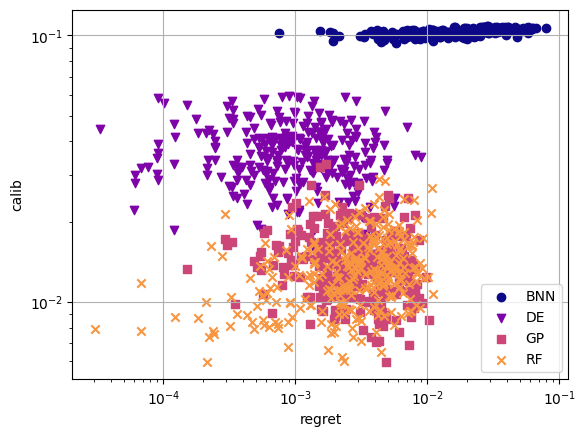

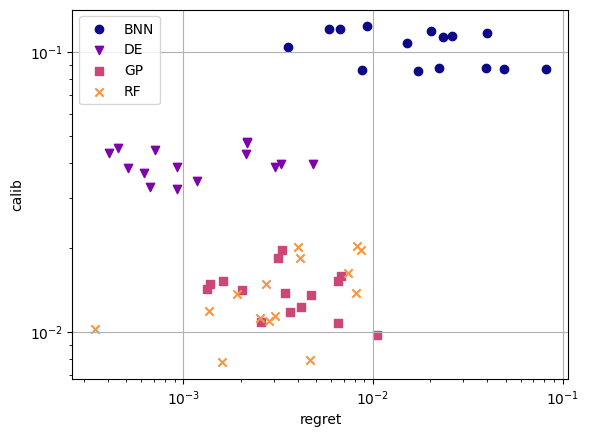

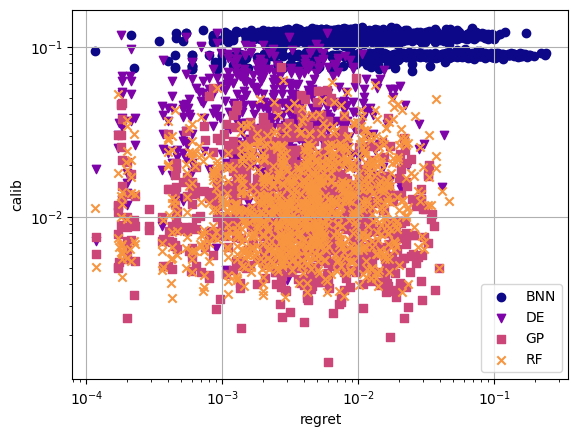

In [38]:
regret_vs_calib_plot(aggregate_real_results_df, aggregate="data")
regret_vs_calib_plot(aggregate_real_results_df, aggregate="seeds")
regret_vs_calib_plot(aggregate_real_results_df)
#regret_vs_calib_plot(aggregate_synth_results_df, aggregate="seeds")

In [ ]:
#DONE: Syntestiske eksperiment check - dimension indexering? 
#ANSWER: Indexeres efter dimension også problem. Hvis aggregate, over både problem idx og dimension.
#DONE: Ændre np.sqrt(n) i standard error of the mean.

#DONE: Horizontal line at the end of each acquisition.
#DONE: Insert midrule automatically.
#ANSWER: Simpler to just do this stuff manually...
#Sæt pertubation eksperimenter over.
#Scatter plot (regret vs. calibration) hvor det er muligt at aggregate fleksibelt.
#Regressions analyse. Inklusiv p værdier. 1. Fuldstændig vanilla regression for alle punkter på slope.


In [47]:
import json
problems = json.load(open("./datasets/benchmarks/unibo-problems.json"))
problems_names = []
for key in problems.keys():
    problems_names.extend(problems[key])
print(set(problems_names))

{'Leon', 'Problem15', 'Problem04', 'MegaDomain04', 'Giunta', 'SumPowers', 'Brent', 'Plateau', 'Brown', 'Ackley', 'Step', 'Cigar', 'Adjiman', 'Sargan', 'Csendes', 'HimmelBlau', 'Quadratic', 'Schwefel06', 'Ursem04', 'McCourt27', 'MegaDomain02', 'Sphere', 'Schwefel20', 'BartelsConn', 'MegaDomain03', 'Problem18', 'Problem13', 'Schwefel22', 'MegaDomain01', 'Schwefel36', 'Schwefel01', 'Exponential', 'McCourt28'}
